In [13]:
from pydub import AudioSegment
import numpy as np
from matplotlib import pyplot as plt

audiosegment=AudioSegment.from_file("audio\it-0936.wav")
data=np.fromstring(audiosegment._data,np.int16)
fs=audiosegment.frame_rate


In [27]:
def get_2D_peaks(arr2D, plot=False, amp_min=30):
# http://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.morphology.iterate_structure.html#scipy.ndimage.morphology.iterate_structure
    struct = generate_binary_structure(2, 1)
    neighborhood = iterate_structure(struct, 10) #peak_neighborhood_size

# find local maxima using our fliter shape
    local_max = maximum_filter(arr2D, footprint=neighborhood) == arr2D
    background = (arr2D == 0)
    eroded_background = binary_erosion(background, structure=neighborhood,
                                   border_value=1)

# Boolean mask of arr2D with True at peaks
    detected_peaks = np.bitwise_xor(local_max, eroded_background)

# extract peaks
    amps = arr2D[detected_peaks]
    j, i = np.where(detected_peaks)

# filter peaks
    amps = amps.flatten()
    peaks = zip(i, j, amps)
    peaks_filtered = [x for x in peaks if x[2] > amp_min]  # freq, time, amp

# get indices for frequency and time
    frequency_idx = [x[1] for x in peaks_filtered]
    time_idx = [x[0] for x in peaks_filtered]
    amps_lvl = [x[2] for x in peaks_filtered]

    return frequency_idx, time_idx, amps_lvl


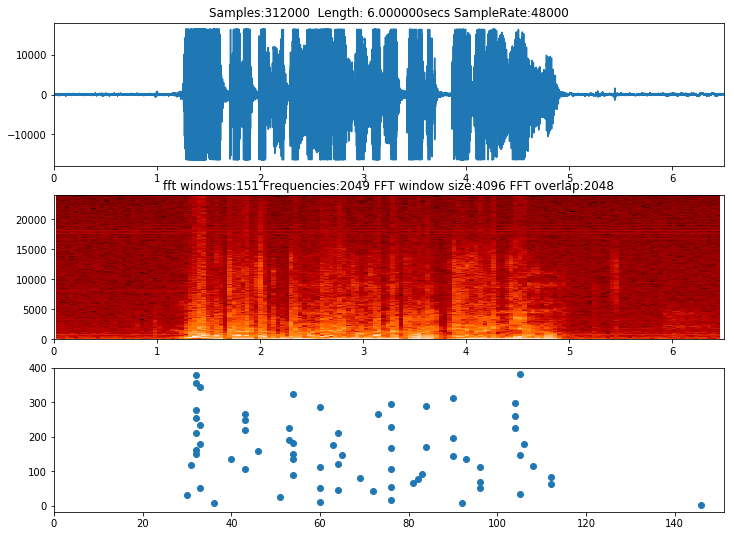

In [30]:
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import (generate_binary_structure,
                                      iterate_structure, binary_erosion)


time=np.arange(0,data.size/float(fs),1/float(fs))
fig1=plt.figure(figsize=(12,9))
ax1 = fig1.add_subplot(311)
plt.plot(time,np.hstack(data))   # for this one has to either undersample or zoom in 
plt.xlim([0,data.size/float(fs)])
title = "Samples:%d  Length: %fsecs SampleRate:%d" % (data.size,data.size/fs, fs)
plt.title(title)

ax2=fig1.add_subplot(312 )  # don't share the axis
Pxx, freqs, bins, im = plt.specgram(
                            np.hstack(data), 
                            NFFT=4096, #FFT window size   
                            Fs=fs,
                            noverlap=2*1024, 
                            cmap=plt.cm.gist_heat)
plt.title("fft windows:%d Frequencies:%d FFT window size:%d FFT overlap:%d" % (bins.size, freqs.size, 4096, 2*1024))
plt.xlim(0,data.size/float(fs))
Pxx = 10 * np.log10(Pxx)
Pxx[Pxx == -np.inf] = 0  # replace infs with zeros

ax3=plt.subplot(313)
frequency_idx,time_idx, amps_lvl = get_2D_peaks(Pxx, plot=False, amp_min=30)
peaks=zip(frequency_idx,time_idx,amps_lvl)
ax3.scatter(time_idx, frequency_idx,picker=5)
plt.xlim([0,bins.size])
# plt.ylim(0,self.freqs.size)
loc_max=zip(frequency_idx, time_idx)

